In [454]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## EDA - Exploratory Data Analysis

In [455]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [456]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

In [457]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

In [458]:
categorical_attributes = df.select_dtypes(include='object')
categorical_attributes.describe()

gender smoker     region
count    1338   1338       1338
unique      2      2          4
top      male     no  southeast
freq      676   1064        364

we will apply one hot encoder for attibutes `gender` and `region`

In [459]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no missing Values

<Axes: >

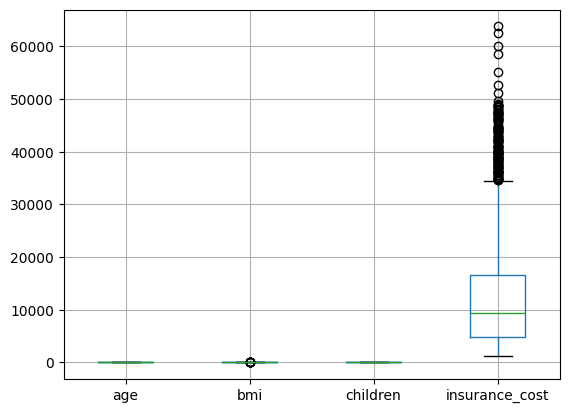

In [460]:
df.boxplot()

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'insurance_cost'}>]], dtype=object)

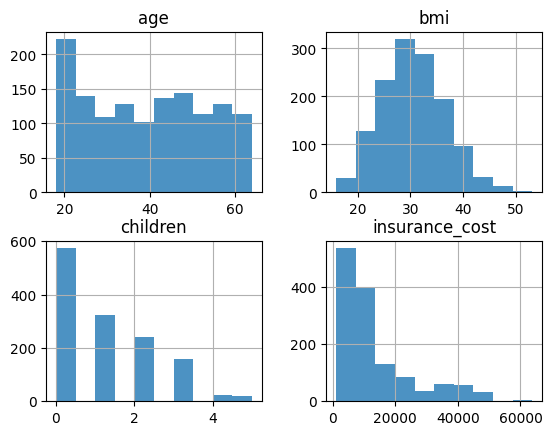

In [461]:
df.hist(bins=10, alpha=0.8)

## Data Preparation

Transform the  `smoker` column to binary.

In [462]:
mapper = {'yes': 1, 'no': 0}
df['smoker'] = df['smoker'].replace(mapper)
df['smoker'].value_counts()

smoker
0    1064
1     274
Name: count, dtype: int64

In [463]:
df.head()

age  gender     bmi  children  smoker     region  insurance_cost
0   18    male  33.770         1       0  southeast      1725.55230
1   18    male  34.100         0       0  southeast      1137.01100
2   18  female  26.315         0       0  northeast      2198.18985
3   18  female  38.665         2       0  northeast      3393.35635
4   18  female  35.625         0       0  northeast      2211.13075

Next we split the columns into a target *`y`* and predictors *`X`*.

In [464]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1)

#### Create Data processing pipleine

Apply one hot encoder for attibutes `gender` and `region`

Attributes `children` is skewed and have values 0 so will apply cube root transformation 

Attributes `age` is less skewed so will apply log transformation

Attribute `bmi` has outliers so will apply robut scalar

In [465]:
categorical_encoding = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("categorical_encoding",categorical_encoding, ['gender','region'] ),
        ("cubic_root_transform", FunctionTransformer(np.cbrt), ['children']),
        ("log_transform", FunctionTransformer(np.log),['age']), 
        ("robust_scaler", RobustScaler(), ['bmi']),    
        
    ],
    remainder="passthrough" # smoker
).set_output(transform="pandas") 

C:\Users\RanganathanD\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [466]:
X_transformed = preprocess_pipeline.fit_transform(X);

In [467]:
X_transformed.head()

categorical_encoding__gender_male  categorical_encoding__region_northwest  \
0                                1.0                                     0.0   
1                                1.0                                     0.0   
2                                0.0                                     0.0   
3                                0.0                                     0.0   
4                                0.0                                     0.0   

   categorical_encoding__region_southeast  \
0                                     1.0   
1                                     1.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   categorical_encoding__region_southwest  cubic_root_transform__children  \
0                                     0.0                        1.000000   
1                                     0.0                        0.000000   
2                                     0.0                        0.000000   
3                                     0.0                        1.259921   
4                                     0.0                        0.000000   

   log_transform__age  robust_scaler__bmi  remainder__smoker  
0            2.890372            0.401310                  0  
1            2.890372            0.440607                  0  
2            2.890372           -0.486454                  0  
3            2.890372            0.984221                  0  
4            2.890372            0.622209                  0

In [468]:
X_transformed.tail()

categorical_encoding__gender_male  \
1333                                0.0   
1334                                0.0   
1335                                1.0   
1336                                1.0   
1337                                1.0   

      categorical_encoding__region_northwest  \
1333                                     0.0   
1334                                     1.0   
1335                                     0.0   
1336                                     0.0   
1337                                     0.0   

      categorical_encoding__region_southeast  \
1333                                     0.0   
1334                                     0.0   
1335                                     0.0   
1336                                     1.0   
1337                                     1.0   

      categorical_encoding__region_southwest  cubic_root_transform__children  \
1333                                     0.0                        1.259921   
1334                                     0.0                        0.000000   
1335                                     0.0                        0.000000   
1336                                     0.0                        1.259921   
1337                                     0.0                        0.000000   

      log_transform__age  robust_scaler__bmi  remainder__smoker  
1333            4.158883            0.169693                  0  
1334            4.158883           -0.418577                  1  
1335            4.158883           -0.475141                  0  
1336            4.158883            0.781185                  1  
1337            4.158883           -0.790712                  1

Now we can split the dataset into a training set and a test sets.

In [469]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Random Forest Pipeline

In [470]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=RandomForestRegressor(n_estimators=10),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [471]:
N_FEATURES_OPTIONS = [2, 3,4,5,6]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(score_func=f_classif)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.852:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__max_depth': 4}


### Linear Regression Pipeline

In [472]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=LinearRegression(),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [473]:
N_FEATURES_OPTIONS = [2,3,4,5,6]
FIT_INTERCEPT_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(score_func=f_classif)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True , error_score='raise')
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.680:
Best parameters:  {'reduce_dim': SelectKBest(), 'reduce_dim__k': 2}


C:\Users\RanganathanD\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


### MLP Regression Pipeline

In [474]:
# pipeline code
pipe = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('ttr', TransformedTargetRegressor(
        regressor=MLPRegressor(),
        func=np.log,
        inverse_func=np.exp))
])

In [475]:
# Existing parameter grid code
N_FEATURES_OPTIONS = [2, 3, 4, 5, 6]
FIT_INTERCEPT_OPTIONS = [False, True]
HIDDEN_LAYER_SIZES_OPTIONS = [(100,), (50, 50), (100, 50, 25)]
ACTIVATION_OPTIONS = ['relu', 'tanh']
ALPHA_OPTIONS = [0.0001, 0.001, 0.01]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__hidden_layer_sizes': HIDDEN_LAYER_SIZES_OPTIONS,
        'ttr__regressor__activation': ACTIVATION_OPTIONS,
        'ttr__regressor__alpha': ALPHA_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__hidden_layer_sizes': HIDDEN_LAYER_SIZES_OPTIONS,
        'ttr__regressor__activation': ACTIVATION_OPTIONS,
        'ttr__regressor__alpha': ALPHA_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(score_func=f_classif)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'ttr__regressor__hidden_layer_sizes': HIDDEN_LAYER_SIZES_OPTIONS,
        'ttr__regressor__activation': ACTIVATION_OPTIONS,
        'ttr__regressor__alpha': ALPHA_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True, error_score='raise')
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

C:\Users\RanganathanD\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


Best CV score = 0.836:
Best parameters:  {'reduce_dim': SelectKBest(), 'reduce_dim__k': 3, 'ttr__regressor__activation': 'relu', 'ttr__regressor__alpha': 0.001, 'ttr__regressor__hidden_layer_sizes': (100, 50, 25)}


In [ ]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [ ]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
MLP_mse, MLP_mae, MLP_r2 = evaluate_model(X_test, y_test, LR_best_model)

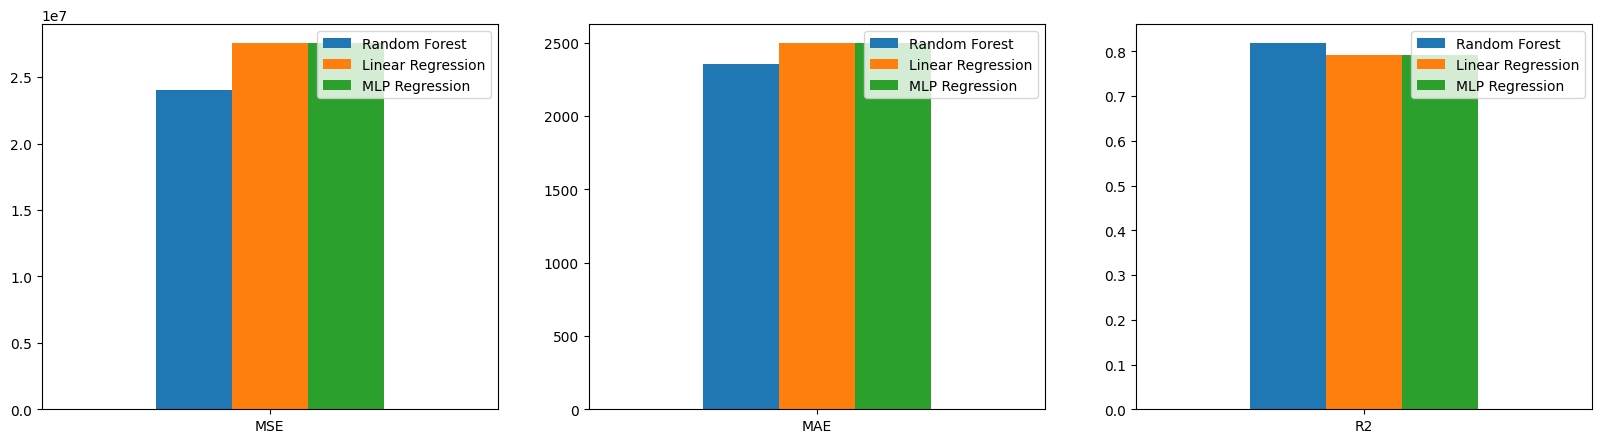

In [ ]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'MLP Regression': MLP_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'MLP Regression': MLP_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'MLP Regression': MLP_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()